In [1]:
import os
import cv2
import math
import time
import pickle
import numpy as np
from random import randint
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

In [2]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) <= (nrows * ncols)
    if labels != "":
        assert len(images) == len(labels)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        if labels != "":
            plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
#Code obtained from Udacity lesson 16
def bin_spatial_Demo_colorspace(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features_demo(img, orient, pix_per_cell, cell_per_block, blockNorm, trns_sqrt, visualize=False, feature_vec=True):
    if visualize == True:
        features, hog_im = hog(img,
                               orientations=orient,
                               pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block),
                               block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                               transform_sqrt=trns_sqrt, 
                               visualise=visualize,
                               feature_vector=feature_vec)
        return features, hog_im
    else:      
        features = hog(img,
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                       transform_sqrt=trns_sqrt, 
                       visualise=visualize,
                       feature_vector=feature_vec)
        return features
    
def normalize(data):
    return preprocessing.normalize(data)

def extractFeatures(img,debug=False,ReturnSizes=False):
    
    hist_feat = []
    SB_feat = []
    hog_feat = []
    
    hist_feat_shape = 0
    SB_feat_shape   = 0
    hog_feat_shape  = 0
    
    histrange = [0,255]
    
    if CHist_EN == True:
        #Extract Color Hitogram Features
        if Hist_colorspace == "HSV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Hist_colorspace == "HLS":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Hist_colorspace == "LAB":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif Hist_colorspace == "YUV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Hist_colorspace == "LUV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Hist_colorspace == "YCrCb":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume No action needed
            hist_image = np.copy(img)
        
        if CS_Ch_Idx != "All":
            hist_feat = cv2.calcHist(hist_image,[CS_Ch_Idx],None,histSize,histrange)
        else:
            hist_feat = []
            for Ch_Idx in range(hist_image.shape[2]):
                hist_feat.append(cv2.calcHist(hist_image,[Ch_Idx],None,histSize,histrange))
        
        hist_feat = np.ravel(hist_feat).reshape(1, -1)

        if debug == True:
            print("Histogram")
            print("Before Normalize")
            print(hist_feat.shape)
            print(hist_feat)
        
        if Nrmlz == True:
            hist_feat = normalize(hist_feat)
            if debug == True:
                print("After Normalize")
                print(hist_feat.shape)
                print(hist_feat)
                
        hist_feat = hist_feat[0]
        hist_feat_shape = hist_feat.shape
        
    if SB_EN == True:
        #Extract Spatial Binning Features
        if Hist_colorspace == "HSV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Hist_colorspace == "HLS":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Hist_colorspace == "LAB":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif Hist_colorspace == "YUV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Hist_colorspace == "LUV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Hist_colorspace == "YCrCb":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume No action needed
            SB_image = np.copy(img)
        
        SB_feat = cv2.resize(SB_image, size).ravel().reshape(1, -1).astype(np.float64)

        if debug == True:
            print("Spatial Binning")
            print("Before Normalize")
            print(SB_feat.shape)
            print(SB_feat)
        
        if Nrmlz == True:
            SB_feat = normalize(SB_feat)
            if debug == True:
                print("After Normalize")
                print(SB_feat.shape)
                print(SB_feat)
                
        SB_feat = SB_feat[0]
        SB_feat_shape = SB_feat.shape
    
    if HOG_EN == True:
        #Extract HOG Features
        if HOG_colorspace == "HSV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif HOG_colorspace == "HLS":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif HOG_colorspace == "LAB":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif HOG_colorspace == "YUV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif HOG_colorspace == "LUV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif HOG_colorspace == "YCrCb":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume No action needed
            hog_image = np.copy(img)
        
        if HOG_Ch_Idx != "All":
            hog_feat = get_hog_features_demo(
                img[:,:,HOG_Ch_Idx],
                orient,
                pix_per_cell,
                cells_per_block,
                blk_Norm,
                visualize=False,
                trns_sqrt=TransformSqrt,
                feature_vec=True)
        else:
            for Ch_Idx in range(hog_image.shape[2]):
                hog_feat.append(get_hog_features_demo(
                    img[:,:,Ch_Idx],
                    orient,
                    pix_per_cell,
                    cells_per_block,
                    blk_Norm,
                    visualize=False,
                    trns_sqrt=TransformSqrt,
                    feature_vec=True))
        
        hog_feat = np.ravel(hog_feat).reshape(1, -1)
        
        if debug == True:
            print("HOG")
            print("Before Normalize")
            print(hog_feat.shape)
            print(hog_feat)
        
        if Nrmlz == True:
            hog_feat = normalize(hog_feat)
            if debug == True:
                print("After Normalize")
                print(hog_feat.shape)
                print(hog_feat)
                
        hog_feat = hog_feat[0]
        hog_feat_shape = hog_feat.shape
    
    if debug == True:
        print("Before Concatenation")
        print(hist_feat)
        print(SB_feat)
        print(hog_feat)
    
    features = np.hstack((hist_feat, SB_feat, hog_feat))
    
    if debug == True:
        print("Output")
        print(len(features))
        print(features)
    
    #features = np.ravel(features)
    
    #if debug == True:
        #print(features.shape)
        #print(features)

    if ReturnSizes == False:
        return features
    else:
        return (hist_feat_shape, 
                SB_feat_shape, 
                hog_feat_shape, 
                features)

In [5]:
Inpath  = "./test_images"
TestimagesPaths = os.listdir(Inpath)

TestImages = CollectImages(Inpath + '/', TestimagesPaths, isLabeled = False)
print("TestImageCollected")

TestImageCollected


In [6]:
def LoadClassifier(Name='TrainedClassifier.pkl'):
    classifier = pickle.load( open(Name, "rb" ) )
    return pickle.load( open(Name, "rb" ) )

In [7]:
classifier = LoadClassifier("TrainedClassifier0.pkl")
clf       = classifier['clf']
Feature_scaler = classifier['Scaler']
CHist_EN  = classifier['CHist_EN']
SB_EN     = classifier['SB_EN']
HOG_EN    = classifier['HOG_EN']
Nrmlz     = classifier['Nrmlz']
histSize  = classifier['histSize']
Hist_colorspace = classifier['Hist_colorspace']
CS_Ch_Idx = classifier['CS_Ch_Idx']
size      = classifier['size']
SB_colorspace   = classifier['SB_colorspace']
HOG_colorspace  = classifier['HOG_colorspace']
orient    = classifier['orient']
pix_per_cell    = classifier['pix_per_cell']
cells_per_block = classifier['cells_per_block']
blk_Norm  = classifier['blk_Norm']
TransformSqrt   = classifier['TransformSqrt']
HOG_Ch_Idx= classifier['HOG_Ch_Idx']

print(clf)
print(Feature_scaler)
print(CHist_EN)
print(SB_EN)
print(HOG_EN)
print(Nrmlz)
print(histSize)
print(Hist_colorspace)
print(CS_Ch_Idx)
print(size)
print(SB_colorspace)
print(HOG_colorspace)
print(orient)
print(pix_per_cell)
print(cells_per_block)
print(blk_Norm)
print(TransformSqrt)
print(HOG_Ch_Idx)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
StandardScaler(copy=True, with_mean=True, with_std=True)
True
True
True
True
[64]
LUV
All
(16, 16)
LUV
LUV
8
16
2
L2
True
All


In [8]:
def draw_boxes(img, bboxes, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, 
                      bbox[0], 
                      bbox[1], 
                      color, 
                      thick)
    # Return the image copy with boxes drawn
    return imcopy

#nearly the same function in lessons
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), debug=False):
    if x_start_stop == [None, None]:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop == [None, None]:
        y_start_stop = [0, img.shape[0]]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    if debug == True:
        return (window_list, nx_windows, ny_windows)
    else:
        return window_list

def Check_Frame_For_Car(image, windows):
    
    detected_box = []
    
    for window in windows:
        img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        image_Features = extractFeatures(img)
        scaled_image_Features = Feature_scaler.transform(image_Features.reshape(1, -1))
        #print(scaled_image_Features.shape)
        isCar = clf.predict(scaled_image_Features)
        #print(isCar)
        if isCar == True:
            detected_box.append(window)
    return detected_box

In [9]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

16
4
[512, 1280] 768 48.0
[360, 684] 324 81.0


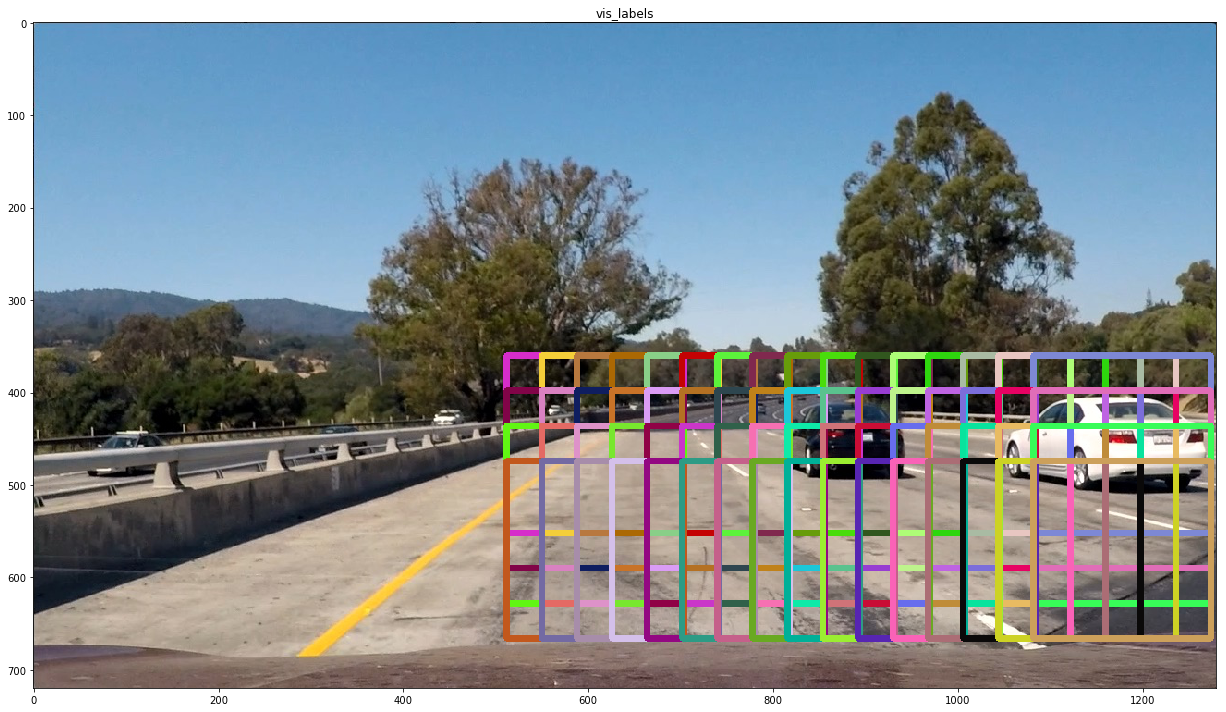

In [10]:
y = TestImages[0].shape[0]
x = TestImages[0].shape[1]

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]

windows= slide_window(TestImages[0], x_start_stop=x_s_s, y_start_stop=y_s_s, 
                        xy_window=(192, 192), xy_overlap=(0.8, 0.8), debug=True)

x_dif = x_s_s[1] - x_s_s[0]
y_dif = y_s_s[1] - y_s_s[0]

print(windows[1])
print(windows[2])
print(str(x_s_s) + " " + str(x_dif) + " " + str((x_dif/windows[1])))
print(str(y_s_s) + " " + str(y_dif) + " " + str((y_dif/windows[2])))

window_img = draw_boxes(TestImages[0], windows[0], thick=6)

pltImages([window_img], ["vis_labels"], 1, 1)

In [11]:
for image in TestImages:
    y = image.shape[0]
    x = image.shape[1]
    x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
    y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]
    windows= slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.5, 0.5), debug=False)
    window_img = draw_boxes(image, windows, thick=6)
    #pltImages([window_img], ["vis_labels"], 1, 1)

In [12]:
y = 720
x = 1280

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.75)]

windows_32 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(32, 32), xy_overlap=(0.7, 0.7), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.8)]

#windows_64 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
#                          xy_window=(64, 64), xy_overlap=(0.85, 0.85), debug=False)
windows_64 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                          xy_window=(64, 64), xy_overlap=(0.75, 0.75), debug=False)

x_s_s = [np.int(x * 0.4), np.int(x * 1.00)]
y_s_s = [np.int(y * 0.5), np.int(y * 0.95)]

windows_128 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                           xy_window=(128, 128), xy_overlap=(0.85, 0.85), debug=False)

windows_192 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                           xy_window=(192, 192), xy_overlap=(0.9, 0.9), debug=False)

windows_256 = slide_window(image, x_start_stop=x_s_s, y_start_stop=y_s_s, 
                           xy_window=(256, 256), xy_overlap=(0.95, 0.95), debug=False)

0
0.0
1.424736738204956
1.20172119140625
0.7730588912963867
0.7825806140899658
1
0.0
1.3592517375946045
1.1503260135650635
0.7683098316192627
0.8016571998596191
2
0.0
1.34165358543396
1.1295008659362793
0.7625236511230469
0.8011572360992432
3
0.0
1.3947076797485352
1.154567003250122
0.7555348873138428
0.7986493110656738
4
0.0
1.361647367477417
1.1185011863708496
0.7419993877410889
0.7670345306396484
5
0.0
1.3425681591033936
1.1179580688476562
0.7485141754150391
0.778606653213501


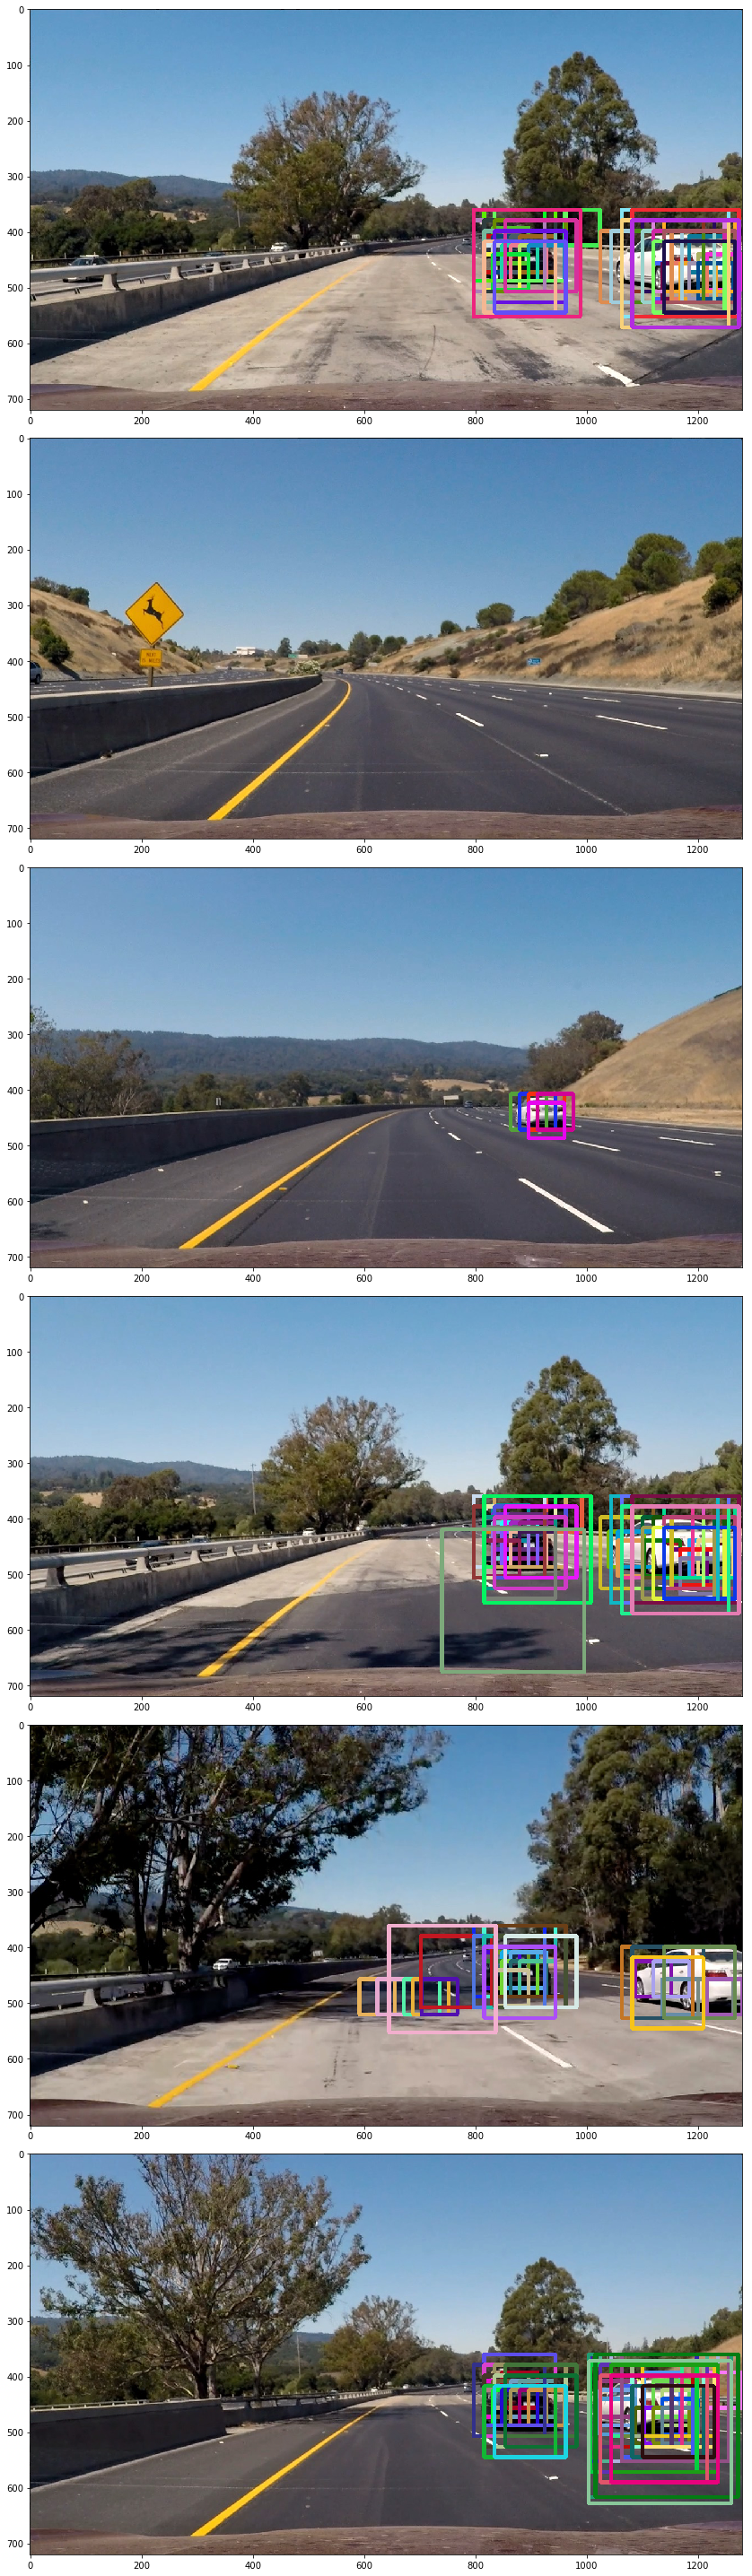

In [13]:
OutputImg = []
counter = 0

for image in TestImages:
    DBox = []
    
    print(counter)
    start_time = time.time()
    #Boxes1 = Check_Frame_For_Car(image, windows_32)
    print(time.time() - start_time)
    start_time = time.time()
    Boxes2 = Check_Frame_For_Car(image, windows_64)
    print(time.time() - start_time)
    start_time = time.time()
    Boxes3 = Check_Frame_For_Car(image, windows_128)
    print(time.time() - start_time)
    start_time = time.time()
    Boxes4 = Check_Frame_For_Car(image, windows_192)
    print(time.time() - start_time)
    start_time = time.time()
    Boxes5 = Check_Frame_For_Car(image, windows_256)
    print(time.time() - start_time)
    
    counter = counter + 1
    
    #for box in Boxes1:
    #    DBox.append(box)
    for box in Boxes2:
        DBox.append(box)
    for box in Boxes3:
        DBox.append(box)
    for box in Boxes4:
        DBox.append(box)
    for box in Boxes5:
        DBox.append(box)
    
    OutputImg.append(draw_boxes(image, DBox, thick=6))

pltImages(OutputImg, "", 6, 1, 20, 40)

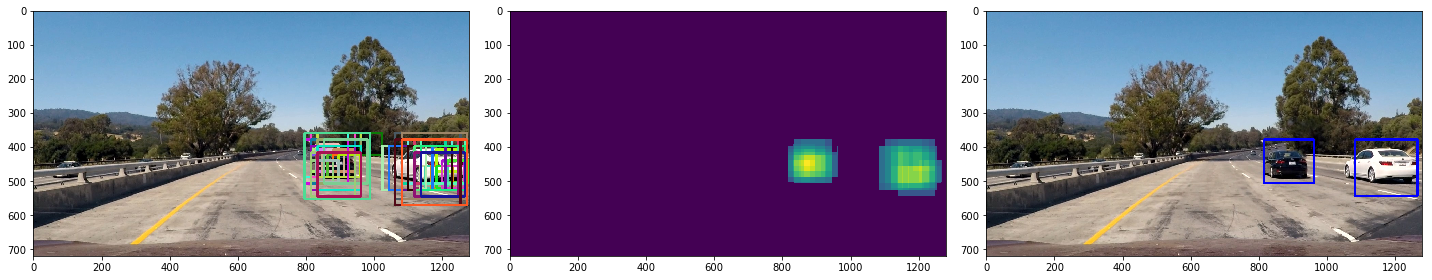

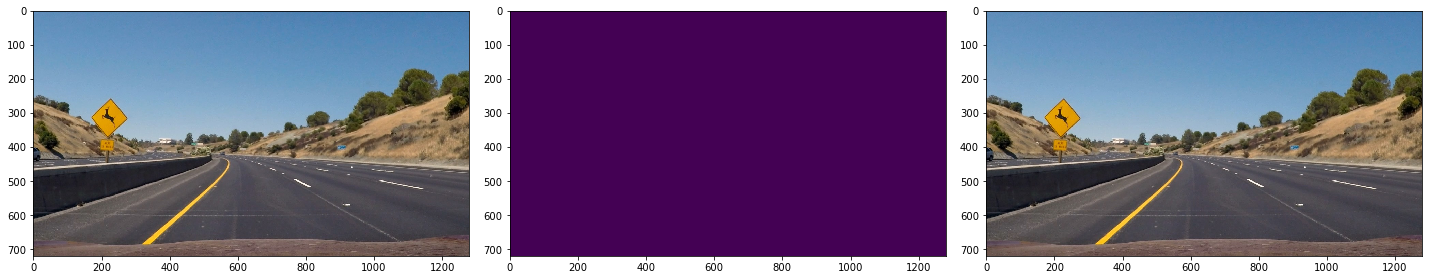

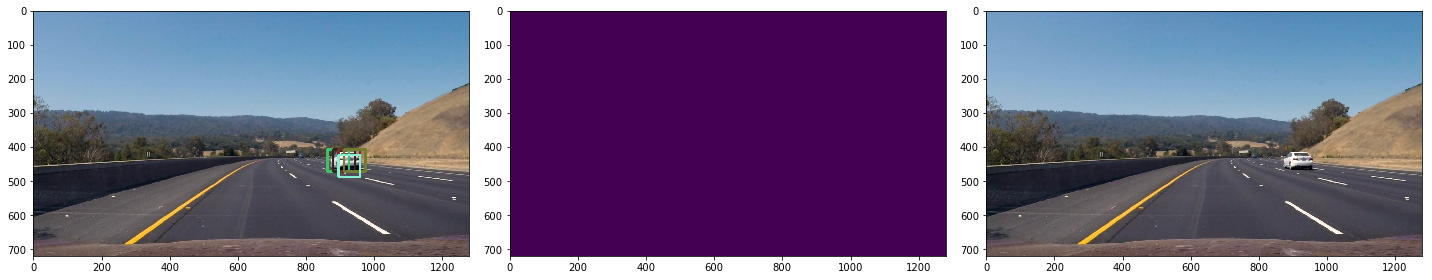

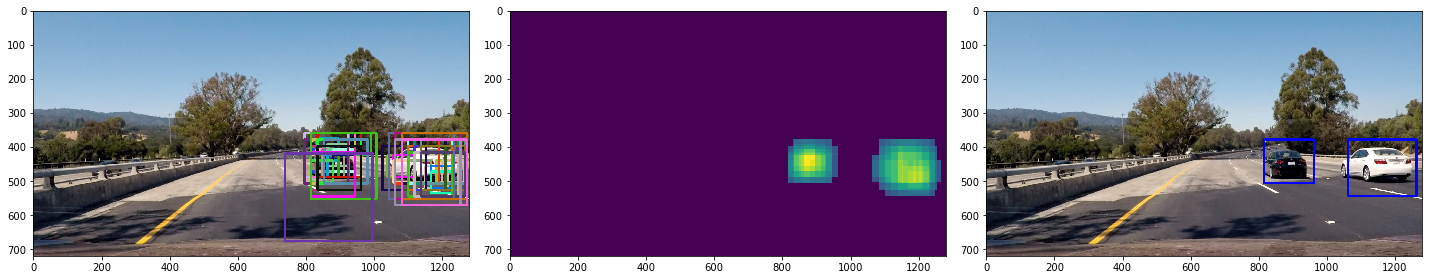

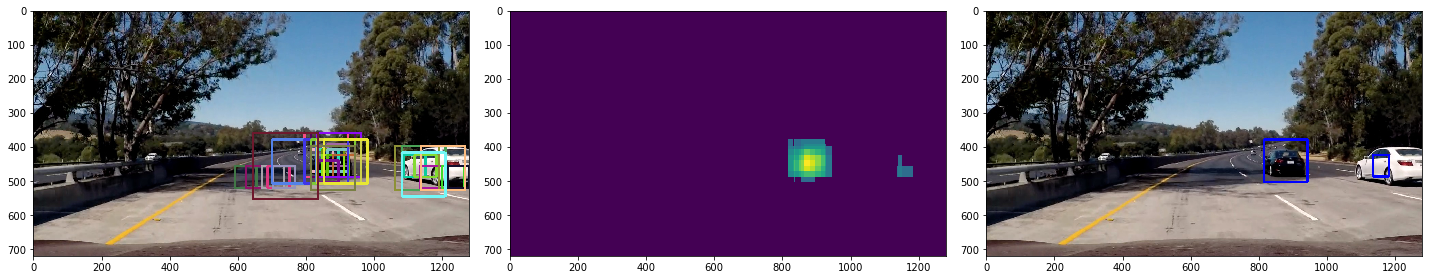

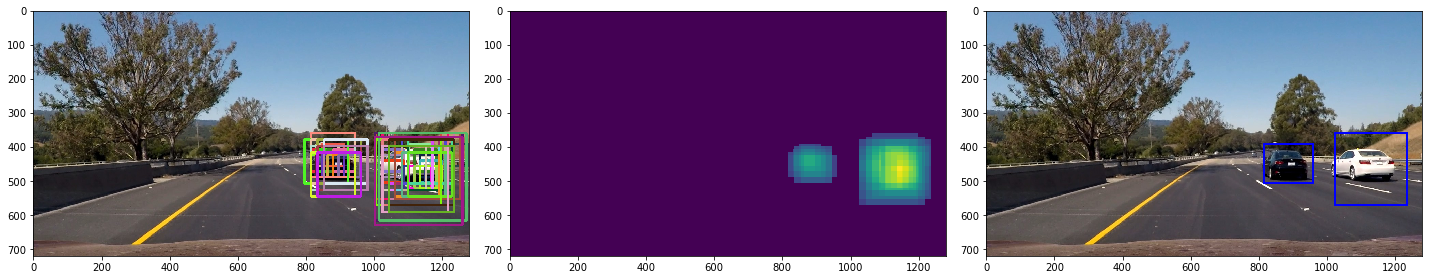

In [14]:
OutputImg = []

for image in TestImages:
    DBox = []
    
    #Boxes1 = Check_Frame_For_Car(image, windows_32)
    Boxes2 = Check_Frame_For_Car(image, windows_64)
    Boxes3 = Check_Frame_For_Car(image, windows_128)
    Boxes4 = Check_Frame_For_Car(image, windows_192)
    Boxes5 = Check_Frame_For_Car(image, windows_256)
    
    #for box in Boxes1:
    #    DBox.append(box)
    for box in Boxes2:
        DBox.append(box)
    for box in Boxes3:
        DBox.append(box)
    for box in Boxes4:
        DBox.append(box)
    for box in Boxes5:
        DBox.append(box)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, DBox)
    heat = apply_threshold(heat,5)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    pltImages([draw_boxes(image, DBox, thick=6), heat, draw_img], "", 1, 3)
    
    #OutputImg.append(draw_boxes(image, DBox, thick=6))

#pltImages(OutputImg, "", 6, 1, 20, 40)

In [15]:
def ProcessVideoFrame(image):
    #Boxes1 = Check_Frame_For_Car(image, windows_32)
    Boxes2 = Check_Frame_For_Car(image, windows_64)
    Boxes3 = Check_Frame_For_Car(image, windows_128)
    Boxes4 = Check_Frame_For_Car(image, windows_192)
    Boxes5 = Check_Frame_For_Car(image, windows_256)
    
    DBox = []
    
    #for box in Boxes1:
    #    DBox.append(box)
    for box in Boxes2:
        DBox.append(box)
    for box in Boxes3:
        DBox.append(box)
    for box in Boxes4:
        DBox.append(box)
    for box in Boxes5:
        DBox.append(box)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, DBox)
    heat = apply_threshold(heat,7)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [16]:
project_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(ProcessVideoFrame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:27<00:03,  3.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 2min 28s


In [17]:
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(ProcessVideoFrame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:22:21<00:04,  4.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 1h 22min 22s
